(https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Cassandra1.jpeg/800px-Cassandra1.jpeg)
## Notebook to run serial methods

With this notebook you can run live/backtest Kaissandra, plot live results and much more

In [1]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")
    
import pandas as pd
import datetime as dt
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ added to python path


## Init Util Functions and Constants 

In [13]:
def get_positions_filename(asset, open_dt, close_dt):
    """  """
    
    dt_open = dt.datetime.strftime(dt.datetime.strptime(
            open_dt,'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    dt_close = dt.datetime.strftime(dt.datetime.strptime(
            close_dt,'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    filename = 'O'+dt_open+'C'+dt_close+asset
    return filename

In [115]:
live = False

if live:
    ext = '_LI_'
    directory = 'kaissandra_live/live'
    start_time = '19_01_27_23_18_41'
else:
    ext = '_BT_'
    directory = 'back_test'
    start_time = '19_02_15_17_30_37'
results_dir = '../../RNN/resultsLive/'+directory+'/trader/'
pos_dirname = results_dir
pos_filename = start_time+ext+"positions_soll.log"
positions_dir = '../../RNN/resultsLive/'+directory+'/positions/'+start_time+'/'
filename = results_dir+start_time+ext+"positions_soll.log"
positions = pd.read_csv(filename).sort_values(by=['Entry Time']).reset_index().drop(labels='index',axis=1)
#print(positions)

4.508769538129034
-0.4648461545564273
-46.48461545564268
0       3.815473
1       2.964165
2      -1.956519
3     -14.279463
4     -12.911705
5       2.455852
6      -5.424496
7      22.604604
8       9.640899
9      38.351237
10     30.873762
11     10.325562
12     18.254367
13     22.614306
14     -2.402467
15      3.090262
16     14.498259
17     31.481179
18     -0.114359
19    -38.652868
20     20.341320
21      9.101076
22      0.077868
23      7.608696
24     17.753662
25     21.857406
26     -2.078666
27      7.252401
28     -3.853639
29     -0.840506
         ...    
242     1.036126
243     6.288548
244    10.904872
245    15.358145
246     6.890480
247     1.490823
248    12.601833
249    -1.119158
250   -22.970378
251    -0.069985
252     3.901499
253    -6.296392
254    15.082032
255    -6.088223
256    -4.837595
257   -12.252661
258   -11.438892
259     4.621072
260   -15.091461
261     1.009721
262    18.528120
263   -38.275653
264   -21.060778
265     4.566870
266     

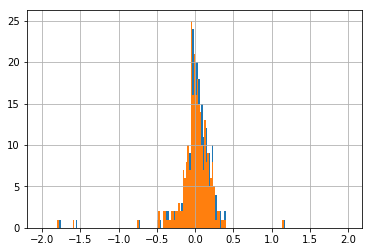

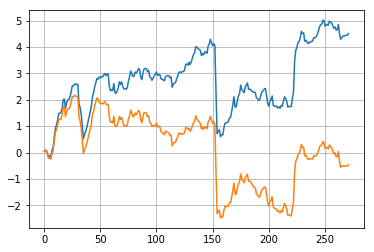

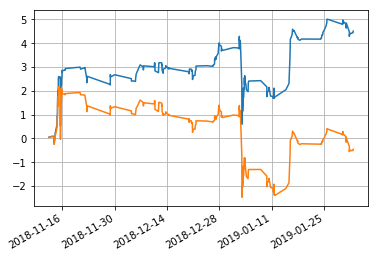

In [116]:
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt


import pandas as pd

print(positions.GROI.sum())
print(positions.ROI.sum())
print(positions.Profit.sum())
print(positions.Profit)

tgroi = positions['GROI'].sum()
troi = positions['ROI'].sum()
tprofit = positions['Profit'].sum()
mspread = positions['Spread'].mean()
emspread = positions['E_spread'].mean()
SIs = positions.agg({'GROI': lambda x: 100*np.sum(x>0)/len(x),
                      'ROI': lambda x: 100*np.sum(x>0)/len(x)})
av_win = sum(positions[positions['GROI']>0]['GROI'])/len(positions[positions['GROI']>0]['GROI'])
av_lose = sum(positions[positions['GROI']<0]['GROI'])/len(positions[positions['GROI']<0]['GROI'])
per_under_2p = 100*positions[positions['Spread']<0.02].shape[0]/pos_format.shape[0]

print("Total GROI = {0:.2f}% ".format(tgroi)+"Total ROI = {0:.2f}% ".format(troi)+"total profit = {0:.2f}e ".format(tprofit)+"mean spread = {0:.2f} pips ".format(100*mspread)+
      "expected mean spread = {0:.2f} pips ".format(100*emspread))
print("Number entries "+str(positions.shape[0])+" GSP = {0:.2f}% ".format(SIs['GROI'])+" NSP = {0:.2f}% ".format(SIs['ROI'])+" av win = {0:.3f}% ".format(av_win)+" av lose = {0:.3f}% ".format(av_lose))
print("Percent below 2p {0:.2f}%".format(per_under_2p))
#print(pd.DataFrame(prob_rois))
grouped = positions.groupby(['Asset'])
#print(grouped.get_group(('GBPJPY',1)).to_string())
#grouped.aggregate(np.sum)
#grouped['groi'].describe()
#grouped.get_group('GBPJPY')
SI = grouped.agg({'GROI': lambda x: np.sum(x>0)/len(x),
             'ROI': lambda x: np.sum(x>0)/len(x)})#.rename(['GSI','NSI'])
grouped.agg({'E_spread': lambda x: 100*np.sum(x<0.02)/len(x)})
#print(SI)
#print(grouped.describe())
#for name, group in grouped:
    #print(name)
#    print(group.to_string())

plt.figure(0)
bins = [i/100 for i in range(-200,200,2)]
histG = plt.hist(positions['GROI'], bins=bins)
histR = plt.hist(positions['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(positions.shape[0]),positions['GROI'].cumsum())
plt.plot(range(positions.shape[0]),positions['ROI'].cumsum())
plt.grid()

list_dates = [dt.datetime.strptime(date, '%Y.%m.%d %H:%M:%S') for date in positions['Entry Time']]
dates = matplotlib.dates.date2num(list_dates)
plt.figure(2)
plt.plot_date(list_dates, positions['GROI'].cumsum(),fmt='-')
plt.plot_date(list_dates, positions['ROI'].cumsum(),fmt='-')
plt.gcf().autofmt_xdate()
plt.grid()

## Build Stats File and Plot Positions

In [117]:
columns = ['asset','Di','Ti','Do','To','direction','groi','roi','profit','e_spread','spread','max','min','argmax','argmin','samples','extensions','stoploss','file']
pos_format = pd.DataFrame(data=0,columns=columns,index=range(positions.shape[0]))
plt_index = 0
for p in range(positions.shape[0]):
    #print(positions.iloc[p])
    pos_format['asset'].iloc[p] = positions['Asset'].iloc[p]
    pos_format['Di'].iloc[p] = positions['Entry Time'].iloc[p][:10]
    pos_format['Ti'].iloc[p] = positions['Entry Time'].iloc[p][11:]
    pos_format['Do'].iloc[p] = positions['Exit Time'].iloc[p][:10]
    pos_format['To'].iloc[p] = positions['Exit Time'].iloc[p][11:]
    pos_format['groi'].iloc[p] = positions['GROI'].iloc[p]
    pos_format['roi'].iloc[p] = positions['ROI'].iloc[p]
    pos_format['e_spread'].iloc[p] = positions['E_spread'].iloc[p]
    pos_format['spread'].iloc[p] = positions['Spread'].iloc[p]
    pos_format['profit'].iloc[p] = positions['Profit'].iloc[p]
    pos_format['stoploss'].iloc[p] = positions['stoploss'].iloc[p]
    direction = positions['Position'].iloc[p]
    pos_format['direction'].iloc[p] = direction
    filename_pos = get_positions_filename(positions['Asset'].iloc[p], positions['Entry Time'].iloc[p], positions['Exit Time'].iloc[p])
    pos_format['file'].iloc[p] = filename_pos
    pos_ev = pd.read_csv(positions_dir+filename_pos+'.txt', sep=',')
    pos_track = pickle.load( open( positions_dir+filename_pos+".p", "rb" ))
    pos_format['extensions'].iloc[p] = pos_track['n_ext']
    pos_format['samples'].iloc[p] = pos_ev.shape[0]
    #print(pos_ev.columns)
    maxBid = pos_ev['SymbolBid'].max()
    minBid = pos_ev['SymbolBid'].min()
    maxAsk = pos_ev['SymbolAsk'].max()
    minAsk = pos_ev['SymbolAsk'].min()
    Bi = positions['Bi'].iloc[p]
    Ai = positions['Ai'].iloc[p]
    #if direction>0:
    #        GROI_live = roi_ratio*(Ao-Ai)/Ai
    #        spread = (Ao-Bo)/Ai
    #        
    #    else:
    #        GROI_live = roi_ratio*(Bi-Bo)/Ao
    if direction>0:
        pos_format['max'].iloc[p] = 100*(maxAsk-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        pos_format['min'].iloc[p] = 100*(minAsk-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        pos_format['argmax'].iloc[p] = pos_ev['SymbolAsk'].idxmax()
        pos_format['argmin'].iloc[p] = pos_ev['SymbolAsk'].idxmin()
        groi_ev = 100*(pos_ev['SymbolAsk'].iloc[:]-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        label = 'long'
    else:
        pos_format['max'].iloc[p] = 100*(positions['Bi'].iloc[p]-minBid)/maxAsk
        pos_format['min'].iloc[p] = 100*(positions['Bi'].iloc[p]-maxBid)/maxAsk
        pos_format['argmax'].iloc[p] = pos_ev['SymbolBid'].idxmax()
        pos_format['argmin'].iloc[p] = pos_ev['SymbolBid'].idxmin()
        groi_ev = 100*(positions['Bi'].iloc[p]-pos_ev['SymbolBid'].iloc[:])/pos_ev['SymbolAsk'].iloc[:]
        label = 'short'
    if positions['GROI'].iloc[p]>0:
        color = 'green'
    else:
        color = 'red'
    #plt.figure(plt_index)
    #plt.plot(groi_ev, color=color, label=label)
    #for e in range(pos_track['n_ext']):
    #    plt.plot([pos_track['@tick#'][e+1] for i in range(2)],[pos_format['min'].iloc[p], pos_format['max'].iloc[p]])
    #plt.legend()
    #plt.title(filename_pos)
    plt_index += 1
print(pos_format.to_string())
pos_format.to_csv(positions_dir+'stats.csv', index=False, sep='\t', float_format='%.5f')
print("Positions summary saved")

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


KeyboardInterrupt: 

## Get Summary from Position Stats

In [17]:
tgroi = pos_format['groi'].sum()
troi = pos_format['roi'].sum()
tprofit = pos_format['profit'].sum()
mspread = pos_format['spread'].mean()
emspread = pos_format['e_spread'].mean()
SIs = pos_format.agg({'groi': lambda x: 100*np.sum(x>0)/len(x),
                      'roi': lambda x: 100*np.sum(x>0)/len(x)})
av_win = sum(pos_format[pos_format['groi']>0]['groi'])/len(pos_format[pos_format['groi']>0]['groi'])
av_lose = sum(pos_format[pos_format['groi']<0]['groi'])/len(pos_format[pos_format['groi']<0]['groi'])
per_under_2p = 100*pos_format[pos_format['e_spread']<0.02].shape[0]/pos_format.shape[0]

print("Total GROI = {0:.2f}% ".format(tgroi)+"Total ROI = {0:.2f}% ".format(troi)+"total profit = {0:.2f}e ".format(tprofit)+"mean spread = {0:.2f} pips ".format(100*mspread)+
      "expected mean spread = {0:.2f} pips ".format(100*emspread))
print("Number entries "+str(pos_format.shape[0])+" GSP = {0:.2f}% ".format(SIs['groi'])+" NSP = {0:.2f}% ".format(SIs['roi'])+" av win = {0:.3f}% ".format(av_win)+" av lose = {0:.3f}% ".format(av_lose))
print("Percent below 2p {0:.2f}%".format(per_under_2p))
#print(pd.DataFrame(prob_rois))
grouped = pos_format.groupby(['asset'])
#print(grouped.get_group(('GBPJPY',1)).to_string())
#grouped.aggregate(np.sum)
#grouped['groi'].describe()
#grouped.get_group('GBPJPY')
SI = grouped.agg({'groi': lambda x: np.sum(x>0)/len(x),
             'roi': lambda x: np.sum(x>0)/len(x)})#.rename(['GSI','NSI'])
grouped.agg({'e_spread': lambda x: 100*np.sum(x<0.02)/len(x)})
#print(SI)
#print(grouped.describe())
#for name, group in grouped:
    #print(name)
#    print(group.to_string())

Total GROI = 3.20% Total ROI = 0.67% total profit = 67.35e mean spread = 1.89 pips expected mean spread = 1.85 pips 
Number entries 134 GSP = 58.96%  NSP = 50.75%  av win = 0.130%  av lose = -0.129% 
Percent below 2p 76.87%


,e_spread
asset,
AUDCAD,0.000000
AUDJPY,0.000000
CHFJPY,0.000000
EURAUD,66.666667
EURCAD,25.000000
EURCHF,44.444444
EURGBP,91.666667
EURJPY,100.000000
EURUSD,100.000000


## Run KaissandOnline

In [2]:
from kaissandra.runLive import launch
launch()

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Config file ../../config/T0003.config loaded from disk
../../RNN/IOlive/AUDCAD/ Directiory renewed
C:/Users/mgutierrez/AppData/Roaming/MetaQuotes/Terminal/D0E8209F77C8CF37AD8BF550E51FF075/MQL5/Files/IOlive/AUDCAD/ Directiory created
../../RNN/IOlive/AUDCAD/ Directiory created
../../RNN/IOlive/EURAUD/ Directiory renewed
C:/Users/mgutierrez/AppData/Roaming/MetaQuotes/Terminal/D0E8209F77C8CF37AD8BF550E51FF075/MQL5/Files/IOlive/EURAUD/ Directiory created
../../RNN/IOlive/EURAUD/ Directiory created
../../RNN/IOlive/EURCAD/ Directiory renewed
C:/Users/mgutierrez/AppData/Roaming/MetaQuotes/Terminal/D0E8209F77C8CF37AD8BF550E51FF075/MQL5/Files/IOlive/EURCAD/ Directiory created
../../RNN/IOlive/EURCAD/ Directiory created
../../RNN/IOlive/EURCHF/ Directiory renewed
C:/Users/mgutierrez/AppData/Roaming/MetaQuotes/Terminal/D0E8209F77C8CF37AD8BF550E51FF075/MQL5/Files/IOlive/EURCHF/ Directiory created
../../RNN/IOlive/EURCHF/ Directiory created
../../RNN/IOlive/EURGBP/ Directiory renewed
C:/Users/mgut

In [107]:
import kaissandra.control as ct
ct.pause()

USDSGD
Asset not running
EURJPY
GBPJPY
EURDKK
Asset not running
EURCZK
Asset not running
EURUSD
GBPUSD
GBPCAD
GBPCHF
NZDUSD
USDCAD
USDHKD
Asset not running
USDPLN
Asset not running
XAUUSD
Asset not running
CADJPY
CHFJPY
EURPLN
Asset not running
XAGUSD
Asset not running
USDCHF
USDRUB
Asset not running
EURGBP
EURAUD
USDJPY
USDMXN
Asset not running
EURCHF
USDNOK
Asset not running
GBPAUD
[USDX]
Asset not running
GOLD
Asset not running
EURCAD
EURNZD
AUDJPY
AUDCAD


In [108]:
import kaissandra.control as ct
ct.resume()

USDSGD
FileNotFoundError
EURJPY
GBPJPY
EURDKK
FileNotFoundError
EURCZK
FileNotFoundError
EURUSD
GBPUSD
GBPCAD
GBPCHF
NZDUSD
USDCAD
USDHKD
FileNotFoundError
USDPLN
FileNotFoundError
XAUUSD
FileNotFoundError
CADJPY
CHFJPY
EURPLN
FileNotFoundError
XAGUSD
FileNotFoundError
USDCHF
USDRUB
FileNotFoundError
EURGBP
EURAUD
USDJPY
USDMXN
FileNotFoundError
EURCHF
USDNOK
FileNotFoundError
GBPAUD
[USDX]
FileNotFoundError
GOLD
FileNotFoundError
EURCAD
EURNZD
AUDJPY
AUDCAD


In [44]:
import kaissandra.control as ct
ct.shutdown()

EURCAD
EURCZK
FileNotFoundError
[USDX]
FileNotFoundError
EURJPY
NZDUSD
EURCHF
AUDCAD
USDHKD
FileNotFoundError
USDMXN
FileNotFoundError
CHFJPY
EURPLN
FileNotFoundError
XAUUSD
FileNotFoundError
EURUSD
EURNZD
USDJPY
GBPCHF
GBPAUD
USDPLN
FileNotFoundError
GBPUSD
USDCHF
XAGUSD
FileNotFoundError
USDCAD
EURDKK
FileNotFoundError
EURGBP
EURAUD
USDRUB
FileNotFoundError
USDSGD
FileNotFoundError
AUDJPY
USDNOK
FileNotFoundError
CADJPY
GBPCAD
GBPJPY
GOLD
FileNotFoundError


In [4]:
# runLive in multiple processes
from multiprocessing import Process
import datetime as dt
import time
%load_ext autoreload
%autoreload 2

from kaissandra.runLive import run

assets = [1, 2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 16, 17, 19, 27, 28, 29, 30, 31, 32]#
running_assets = assets#[7, 14]
start_time = dt.datetime.strftime(dt.datetime.now(),'%y_%m_%d_%H_%M_%S')
#disp = Process(target=run, args=[running_assets,start_time])
#disp.start()
for ass_idx in range(len(running_assets)):
    disp = Process(target=run, args=[running_assets[ass_idx:ass_idx+1],start_time])
    disp.start()
    time.sleep(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get total returns

In [53]:
import pandas as pd
start_time = '19_02_15_17_30_37'
results_dir = '../../RNN/resultsLive/back_test/trader/'
filename = results_dir+start_time+'_BT_'+"positions_soll.log"
positions = pd.read_csv(filename)
print(positions.GROI.sum())
print(positions.ROI.sum())
print(positions.Profit.sum())
print(positions.Profit)

3.398874679876486
0.4184642357582783
41.8464235758278
0       3.815473
1       2.964165
2      -1.956519
3     -14.279463
4       9.640899
5     -12.911705
6      -5.424496
7       2.455852
8      22.604604
9      -4.191491
10      3.090262
11     -2.402467
12     30.873762
13      7.252401
14     22.614306
15     -0.114359
16    -38.652868
17     13.927206
18     20.341320
19     -3.853639
20      4.603808
21     -3.660071
22      9.101076
23     -9.470053
24     -4.326061
25     17.753662
26     14.498259
27    -74.676760
28     -2.078666
29      5.082671
         ...    
125     8.850928
126    -0.883861
127    -5.620702
128   -33.522304
129   -37.970560
130    -4.176478
131    -5.179482
132     3.986393
133    -2.004445
134     4.159402
135   -15.732055
136     3.669212
137     0.787870
138    -5.328455
139     6.416255
140    13.262017
141     8.228611
142    -4.666511
143    -7.889931
144     6.305498
145   -31.740476
146    -9.869035
147    24.870848
148    13.601523
149    -0.4

## Retrieve Positions from Trader Simulation

In [1]:
# Positions file from trader simulation
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 3
start_time = '190212144049'
list_IDresults = ['100350NJLS','100327S','100500L']#
list_IDgre = [None for i in range(numberNetwors)]
list_name = ['100350NJLS_13_3_.65_.6','100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13,21,29]
list_t_index = [3,0,2]
list_spread_ranges = [{'sp':[2.5],'th':[(.65,.6)]},{'sp':[2.5],'th':[(.75,.7)]},{'sp':[2.5],'th':[(.7,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)


190212144049_100350NJLSE13TI3MC0.65MD0.6_100327SE21TI0MC0.75MD0.7_100500LE29TI2MC0.7MD0.6


In [7]:
# Positions file from trader simulation
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 2
start_time = '190213090034'
list_IDresults = ['100327S','100500L']#
list_IDgre = [None for i in range(numberNetwors)]
list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [21,29]
list_t_index = [0,2]
list_spread_ranges = [{'sp':[2.5],'th':[(.75,.7)]},{'sp':[2.5],'th':[(.7,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)


190213090034_100327SE21TI0MC0.75MD0.7_100500LE29TI2MC0.7MD0.6


In [12]:
# Positions file from trader simulation
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 1
start_time = '190213095021'
#E13TI3MC0.65MD0.6
list_IDresults = ['100350NJLS']#
list_IDgre = [None for i in range(numberNetwors)]
#list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13]
list_t_index = [3]
list_spread_ranges = [{'sp':[2.5],'th':[(.65,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)


190213095021_100350NJLSE13TI3MC0.65MD0.6


In [28]:

pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 2
start_time = '190213103037'
#E13TI3MC0.65MD0.6
list_IDresults = ['100350S','100350L']#
list_IDgre = [None for i in range(numberNetwors)]
#list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13,6]
list_t_index = [3,1]
list_spread_ranges = [{'sp':[2.5],'th':[(.55,.6)]},{'sp':[2.5],'th':[(.65,.65)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)

190213103037_100350SE13TI3MC0.55MD0.6_100350LE6TI1MC0.65MD0.65


In [121]:
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 4
start_time = '190213121736'
#E13TI3MC0.65MD0.6
list_IDresults = ['100350S','100350L']+['100327S','100500L']#
list_IDgre = [None for i in range(numberNetwors)]
#list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13,6]+[21,29]
list_t_index = [3,1]+[0,2]
list_spread_ranges = [{'sp':[2.5],'th':[(.55,.6)]},{'sp':[2.5],'th':[(.65,.65)]}]+[{'sp':[2.5],'th':[(.75,.7)]},{'sp':[2.5],'th':[(.7,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)

190213121736_100350SE13TI3MC0.55MD0.6_100350LE6TI1MC0.65MD0.65_100327SE21TI0MC0.75MD0.7_100500LE29TI2MC0.7MD0.6


In [131]:
import pandas as pd

positions = pd.read_csv(pos_dirname+pos_filename+'.csv',sep='\t')#
#print(positions)
pip_limit = 0.1
pos_under_2p = positions['espread']<pip_limit
positions['DTo'] = positions["Do"] + " "+ positions["To"]
pos_under_thr = positions[pos_under_2p]#.sort_values(by=['DTo'])
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(pos_under_thr['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
mean_spread = positions[pos_under_2p]['spread'].mean()
print("total mean GROI")
print(positions['GROI'].mean())
print("mean GROI of selected")
print(positions[pos_under_2p]['GROI'].mean())
print("mean_spread of selected")
print(mean_spread)
print("Number of pos under "+str(pip_limit))
print(positions[pos_under_2p].shape[0])
print("per under pip_limit")
print(per_under_2p)
print("total gross success rate")
print(tgsr)
print("gross success rate")
print(gsr)
print("total success rate")
print(tsr)
print("success rate")
print(sr)
print("GROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['GROI'].sum())
print("ROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['ROI'].sum())
print("positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]")
print(positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0])
print("# Assets")
print(positions['Asset'][pos_under_2p].unique().shape[0])
pos_under_thr.to_csv(pos_dirname+pos_filename+str(100*pip_limit)+'pFilt.csv', index=False, sep='\t')

total mean GROI
0.03938055953427978
mean GROI of selected
0.03938055953427978
mean_spread of selected
0.015472610906212323
Number of pos under 0.1
827
per under pip_limit
100.0
total gross success rate
61.668681983071345
gross success rate
61.668681983071345
total success rate
57.194679564691654
success rate
57.194679564691654
GROI for positions under 0.1
32.5677227348494
ROI for positions under 0.1
19.771873515411812
positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]
-50.132277265150606
# Assets
21


In [134]:
print(827/33)
print(272/12)

25.060606060606062
22.666666666666668


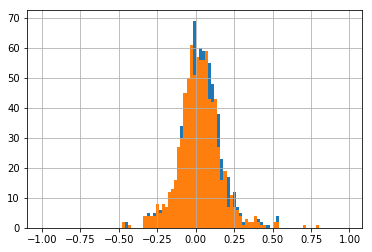

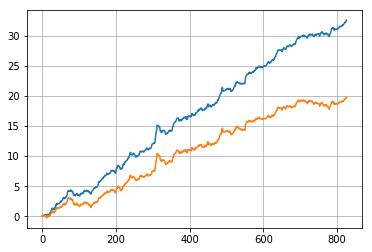

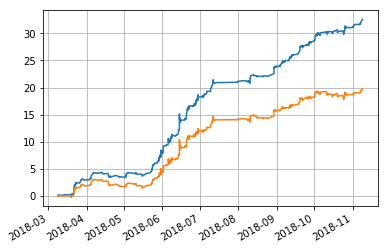

In [132]:
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(0)
bins = [i/100 for i in range(-100,100,2)]
histG = plt.hist(pos_under_thr['GROI'], bins=bins)
histR = plt.hist(pos_under_thr['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.grid()

list_dates = [dt.datetime.strptime(date, '%Y.%m.%d %H:%M:%S') for date in positions['DTo']]
dates = matplotlib.dates.date2num(list_dates)
plt.figure(2)
plt.plot_date(list_dates, pos_under_thr['GROI'].cumsum(),fmt='-')
plt.plot_date(list_dates, pos_under_thr['ROI'].cumsum(),fmt='-')
plt.gcf().autofmt_xdate()
plt.grid()

Asset
AUDCAD    0.542359
AUDJPY    4.152853
CADJPY    0.115273
CHFJPY    0.067865
EURAUD   -0.192700
EURCAD    0.974623
EURCHF   -0.121282
EURGBP    0.617676
EURJPY    1.537915
EURNZD    1.112103
EURUSD    1.527521
GBPAUD    1.596829
GBPCAD    1.356418
GBPCHF    0.236248
GBPJPY    0.958917
GBPUSD    1.845176
GOLD      1.367162
NZDUSD    1.098908
USDCAD    0.587564
USDCHF    0.573920
USDJPY   -0.183477
Name: ROI, dtype: float64


AttributeError: 'Figure' object has no attribute 'autofmt'

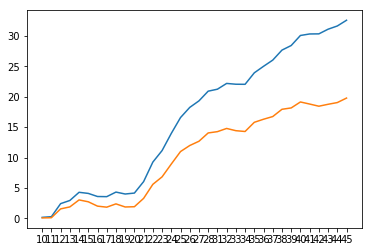

In [37]:
#positions
#grouped = pos_format.groupby(['asset'])
weekly_group = pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['ROI']
weekly_group_G = pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['GROI']
asset_group = pos_under_thr.groupby(['Asset'])
weekly_sum = weekly_group.sum()
weekly_sum_G = weekly_group_G.sum()
weekly_count = weekly_group.count()
#weekly_sum.cumsum()
#print(asset_group['GROI'].sum())
print(asset_group['ROI'].sum())
plt.figure(0)
plt.plot(weekly_sum_G.cumsum())
plt.plot(range(weekly_sum.shape[0]), weekly_sum.cumsum())
plt.gcf().autofmt_xdate()
plt.grid()
print(weekly_sum_G)
print(weekly_sum)#.cumsum()
print(weekly_count)
print(weekly_sum.cumsum())
print(weekly_count.shape)
#print(pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['GROI'].sum())
#print(weekly_count)
plt.figure(1)
plt.grid()
plt.hist(weekly_count, bins=range(0,max(weekly_count),5))

#for name, group in asset_group:
#    print(name)
#    print(group.to_string())
#pd.to_datetime(positions['Di']).dt.strftime('%W')
#pd.to_datetime(positions['Di'])#.groupby('Name').resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')